In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk


from sklearn import preprocessing

In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Importing Data**

In [5]:
path = "/content/drive/MyDrive/Colab Notebooks/NUS_Fintech_Project2/stock_data.csv"
df = pd.read_csv(path)
df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


**Data Preprocessing**

Removing Stopwords

In [8]:
#nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [9]:
raw_features = df['Text'].to_numpy()
raw_features

array(['Kickers watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method 1 method 2, see prev posts',
       'user: AAP MOVIE. 55% return FEA/GEED indicator 15 trades year. AWESOME.',
       "user I'd afraid short AMZN - looking like near-monopoly eBooks infrastructure-as-a-service",
       ...,
       'Workers Bajaj Auto agreed 10% wage cut period April 15 till lockdown lifted. https://t.co/RgvrKPliNd',
       '#Sharemarket LIVE: Sensex day’s high, 600 points, #Nifty tests 9,200, #TCS, private bank stocks lead https://t.co/3xgtLroKUI',
       "#Sensex, #Nifty climb day's highs, still 2%; Key factors driving D-Street higher today https://t.co/jVQcousFp6"],
      dtype=object)

Text Cleaning

In [11]:
import re
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag 
def text_processor(raw_text_arr):
  #remove hyperlinks
  res = re.sub(r'^https?:\/\/.*[\r\n]*', '', raw_text_arr, flags=re.MULTILINE)
  #keep only alphanumerical characters
  res = "".join(char for char in res if ord(char) < 128 and not char.isnumeric())
  def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
      return wordnet.ADJ
    elif treebank_tag.startswith('V'):
      return wordnet.VERB
    elif treebank_tag.startswith('N'):
      return wordnet.NOUN
    elif treebank_tag.startswith('R'):
      return wordnet.ADV
    else:
      return wordnet.NOUN
  lemmatizer = WordNetLemmatizer()
  res = list(map(lambda w: lemmatizer.lemmatize(w[0], pos = get_wordnet_pos(w[1])), pos_tag(res.split())))
  res = ' '.join(res)

  return res

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**Train-Test Split**

In [12]:
X = df['Text'].to_numpy()
X = list(map(text_processor, X))

Y = df['Sentiment'].to_numpy()
Y[Y==-1] = 0

(len(X),len(Y))

(5791, 5791)

In [13]:
from sklearn.model_selection import train_test_split
 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=26, shuffle=True)


In [14]:
print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))


4632
1159
4632
1159


**Tokenization**

In [15]:
num_words = 1000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'
# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)
# Get our training data word index
word_index = tokenizer.word_index




In [16]:
# Encode training data sentences into sequences
X_train_tokenize = tokenizer.texts_to_sequences(X_train)
X_test_tokenize = tokenizer.texts_to_sequences(X_test)

In [18]:
max_length = 30
padding_type='post'
truncation_type='post'

X_train_padded = pad_sequences(X_train_tokenize,maxlen=max_length,padding=padding_type, truncating=truncation_type)
X_test_padded = pad_sequences(X_test_tokenize,maxlen=max_length,padding=padding_type, truncating=truncation_type)

**Word Embedding Layer**

In [19]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2022-12-14 06:21:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-14 06:21:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-14 06:21:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [20]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [21]:
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [22]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

**Training the Model**

In [23]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization

embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False)

In [30]:
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(128, return_sequences=True)), 
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
   Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
history = model.fit(X_train_padded, Y_train, epochs=20, validation_data=(X_test_padded, Y_test))

Epoch 1/20
145/145 [==============================] - 64s 399ms/step - loss: 0.6320 - accuracy: 0.6567 - val_loss: 0.6331 - val_accuracy: 0.6851
Epoch 2/20
145/145 [==============================] - 33s 230ms/step - loss: 0.5519 - accuracy: 0.7174 - val_loss: 0.5741 - val_accuracy: 0.7032
Epoch 3/20
145/145 [==============================] - 34s 232ms/step - loss: 0.5255 - accuracy: 0.7345 - val_loss: 0.5740 - val_accuracy: 0.7161
Epoch 4/20
145/145 [==============================] - 34s 235ms/step - loss: 0.4859 - accuracy: 0.7662 - val_loss: 0.5588 - val_accuracy: 0.7282
Epoch 5/20
145/145 [==============================] - 34s 236ms/step - loss: 0.4491 - accuracy: 0.7884 - val_loss: 0.6331 - val_accuracy: 0.7455
Epoch 6/20
145/145 [==============================] - 34s 234ms/step - loss: 0.4105 - accuracy: 0.8107 - val_loss: 0.5916 - val_accuracy: 0.7204
Epoch 7/20
145/145 [==============================] - 36s 249ms/step - loss: 0.3864 - accuracy: 0.8178 - val_loss: 0.6301 - val_ac

Validation Accuracy: 0.7308024168014526


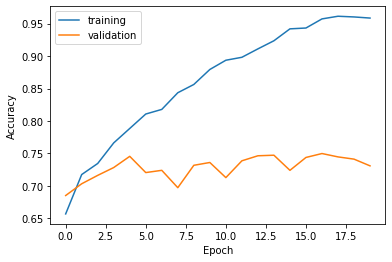

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"],label="training")
plt.plot(history.history["val_accuracy"],label="validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
print("Validation Accuracy: "+ str(history.history["val_accuracy"][-1]))